# Dataset

## Imports and constants

In [28]:
import torch
from torchvision import transforms
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import random
from PIL import Image

from dataset import CoLeafDataset, CoLeafSubset

In [29]:
GRAPH_OUTPUT        = './output/graphs'
DATASET_PATH        = './output/datasets'
DATASET_AUG_PATH    = './CoLeaf_augmented'
TRAIN_SPLIT         = 0.6
IMG_SIZE            = 224

In [20]:
dataset: CoLeafDataset = torch.load(os.path.join(DATASET_PATH, 'dataset.pt'), weights_only=False)

In [38]:
# Split the dataset into train, validation, and test sets (60/20/20)
range_train, range_temp = train_test_split(
    range(len(dataset)),
    train_size=TRAIN_SPLIT,
    stratify=dataset.labels
)
range_valid, range_test = train_test_split(
    range_temp,
    test_size=0.5,
    stratify=[dataset.labels[i] for i in range_temp]
)

train_dataset = CoLeafSubset(dataset, range_train)
val_dataset = CoLeafSubset(dataset, range_valid)
test_dataset  = CoLeafSubset(dataset, range_test)

In [4]:
torch.save(train_dataset, os.path.join(DATASET_PATH, 'train_dataset.pt'))
torch.save(val_dataset, os.path.join(DATASET_PATH, 'val_dataset.pt'))
torch.save(test_dataset, os.path.join(DATASET_PATH, 'test_dataset.pt'))

## Overview
The dataset consists of images of coffee leaves with varios nutrient deficiencies.

In [39]:
im, train_im, val_im, test_im = [], [], [], []

for i in range(max(dataset.labels)+1):
    im.append(dataset.labels.count(i))
    train_im.append(train_dataset.labels.count(i))
    val_im.append(val_dataset.labels.count(i))
    test_im.append(test_dataset.labels.count(i))

df = pd.DataFrame({"Class": dataset.classes, "Number of images": im})
df_train = pd.DataFrame({"Class": dataset.classes, "Number of images": train_im})
df_val = pd.DataFrame({"Class": dataset.classes, "Number of images": val_im})
df_test = pd.DataFrame({"Class": dataset.classes, "Number of images": test_im})

In [15]:
def plot_images_per_class(df: pd.DataFrame, dataset: str):
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle(f'Image distribution per class in {dataset}', fontsize=20)

    df_sorted = df.sort_values(by="Number of images", ascending=False)
    colors = sns.color_palette('tab20', len(df_sorted))

    # Bar plot
    ax_bar = sns.barplot(ax=axes[0], x="Class", y="Number of images", data=df_sorted, palette=colors, hue="Class", legend=False)

    for p in ax_bar.patches:
        ax_bar.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), 
                    textcoords='offset points')

    axes[0].tick_params(axis='x', rotation=45)

    # Pie chart
    axes[1].pie(df_sorted["Number of images"], labels=df_sorted["Class"], autopct='%1.1f%%', startangle=140, colors=colors)
    axes[1].axis('equal') 

    plt.tight_layout()
    plt.show()
    
    plt.savefig(os.path.join(GRAPH_OUTPUT, f'images_per_class_{dataset}.png'))

Full datset: 1006 images


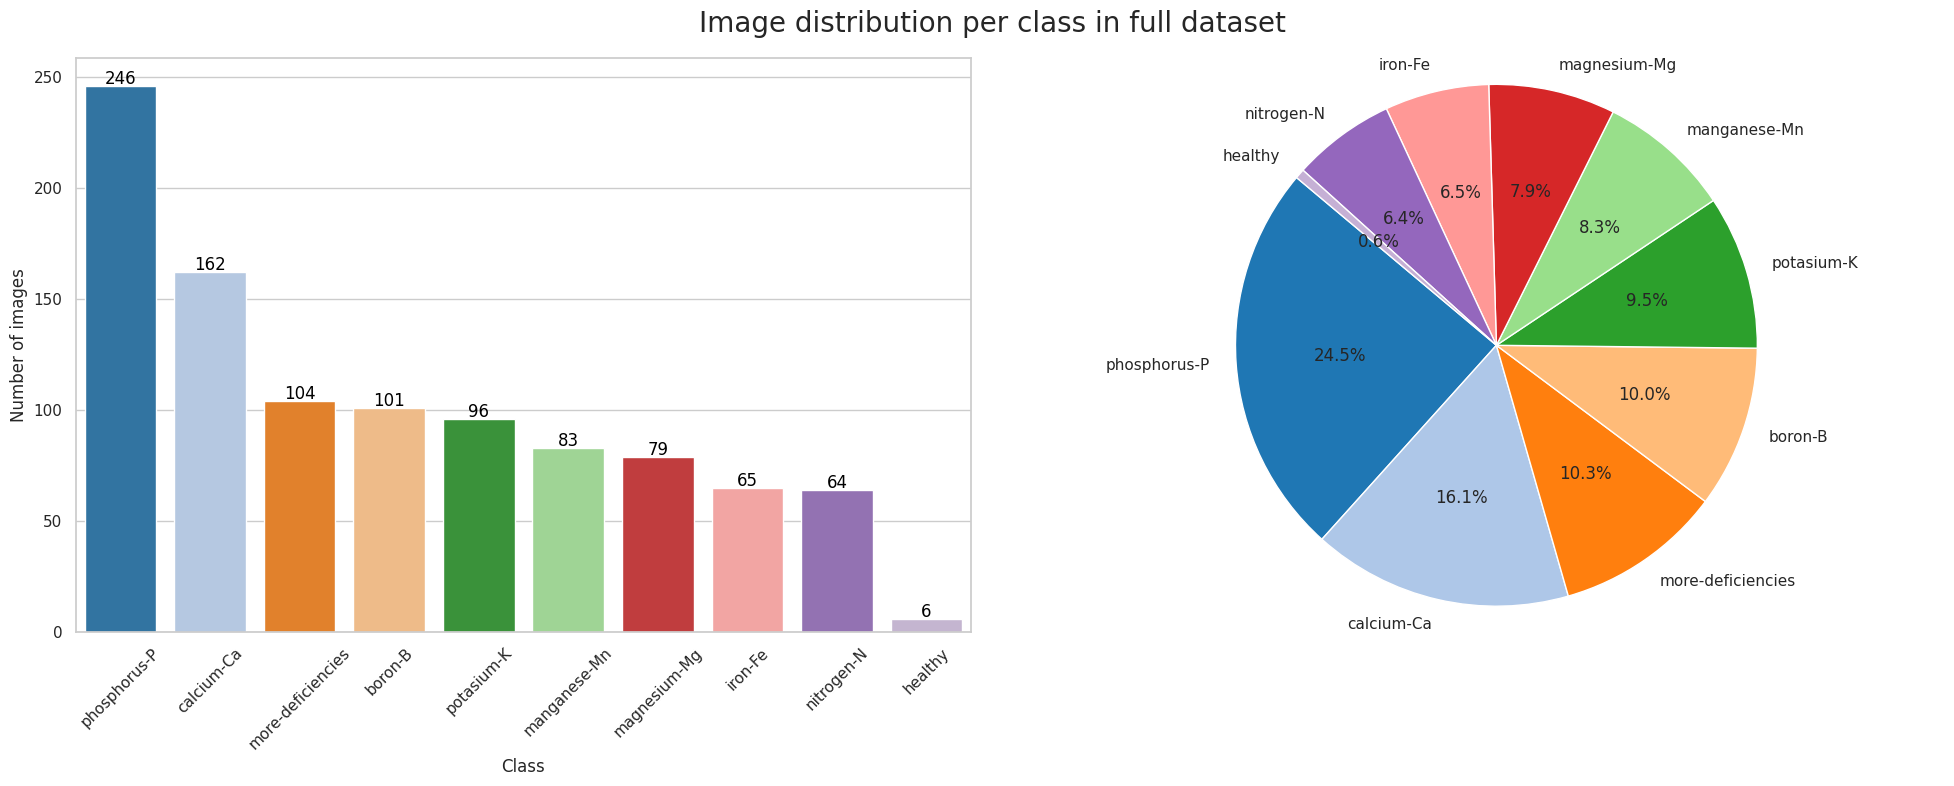

<Figure size 640x480 with 0 Axes>

In [16]:
print(f"Full datset: {len(dataset)} images")
plot_images_per_class(df, 'full dataset')

Train dataset: 603 images


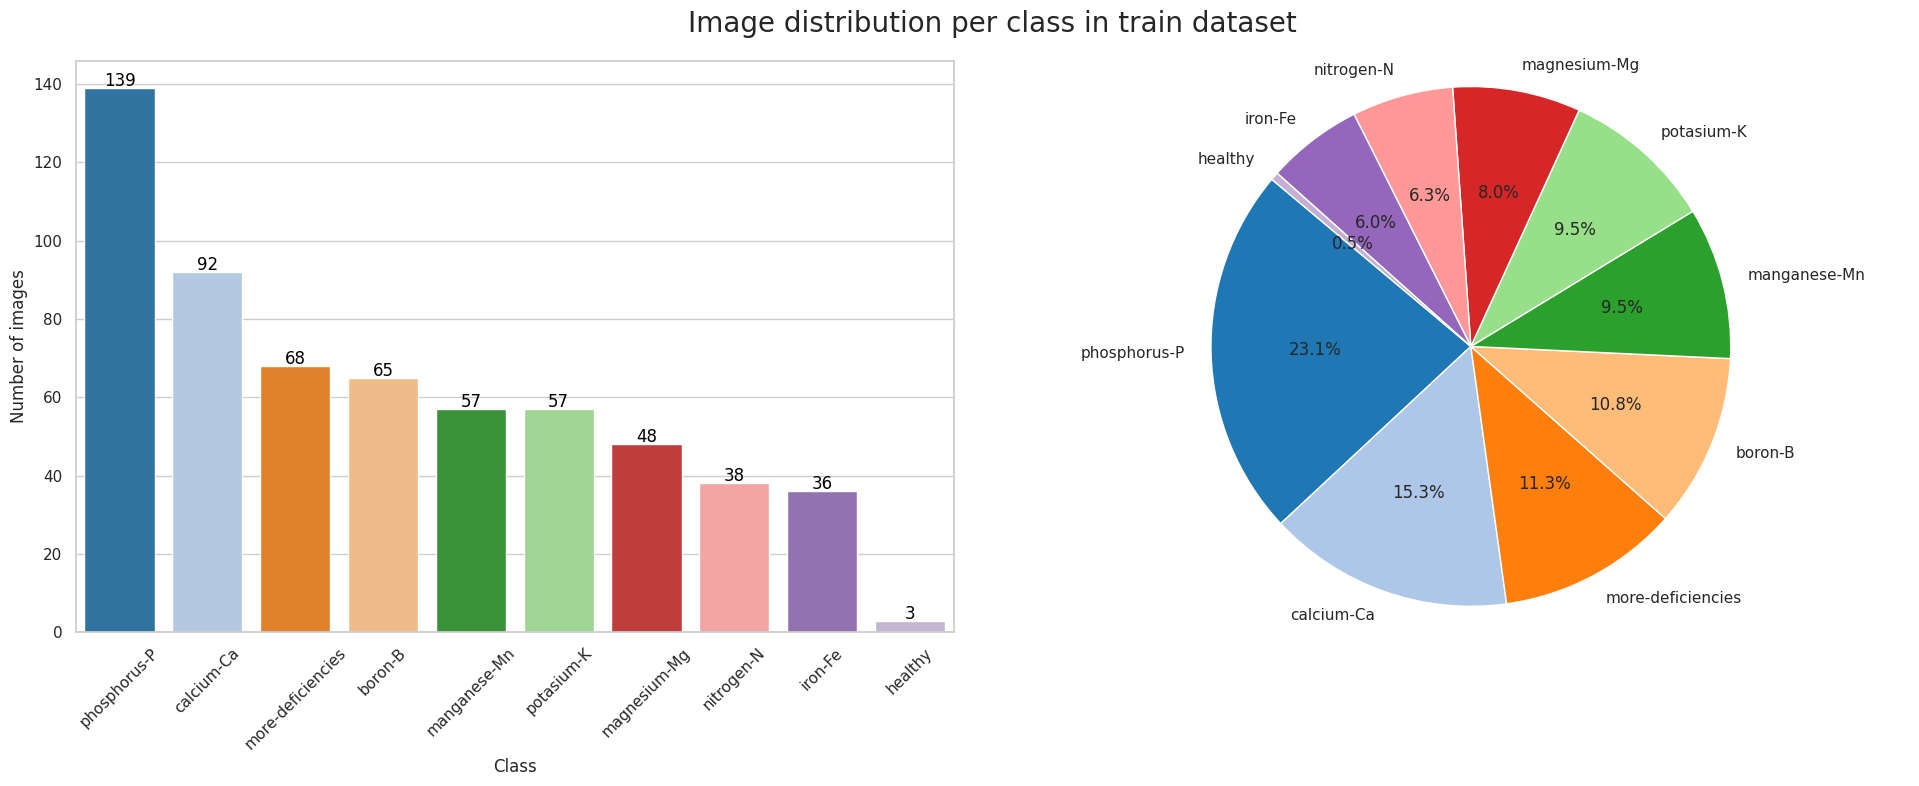

<Figure size 640x480 with 0 Axes>

In [23]:
print(f"Train dataset: {len(train_dataset)} images")
plot_images_per_class(df_train, 'train dataset')

Validation dataset: 201 images


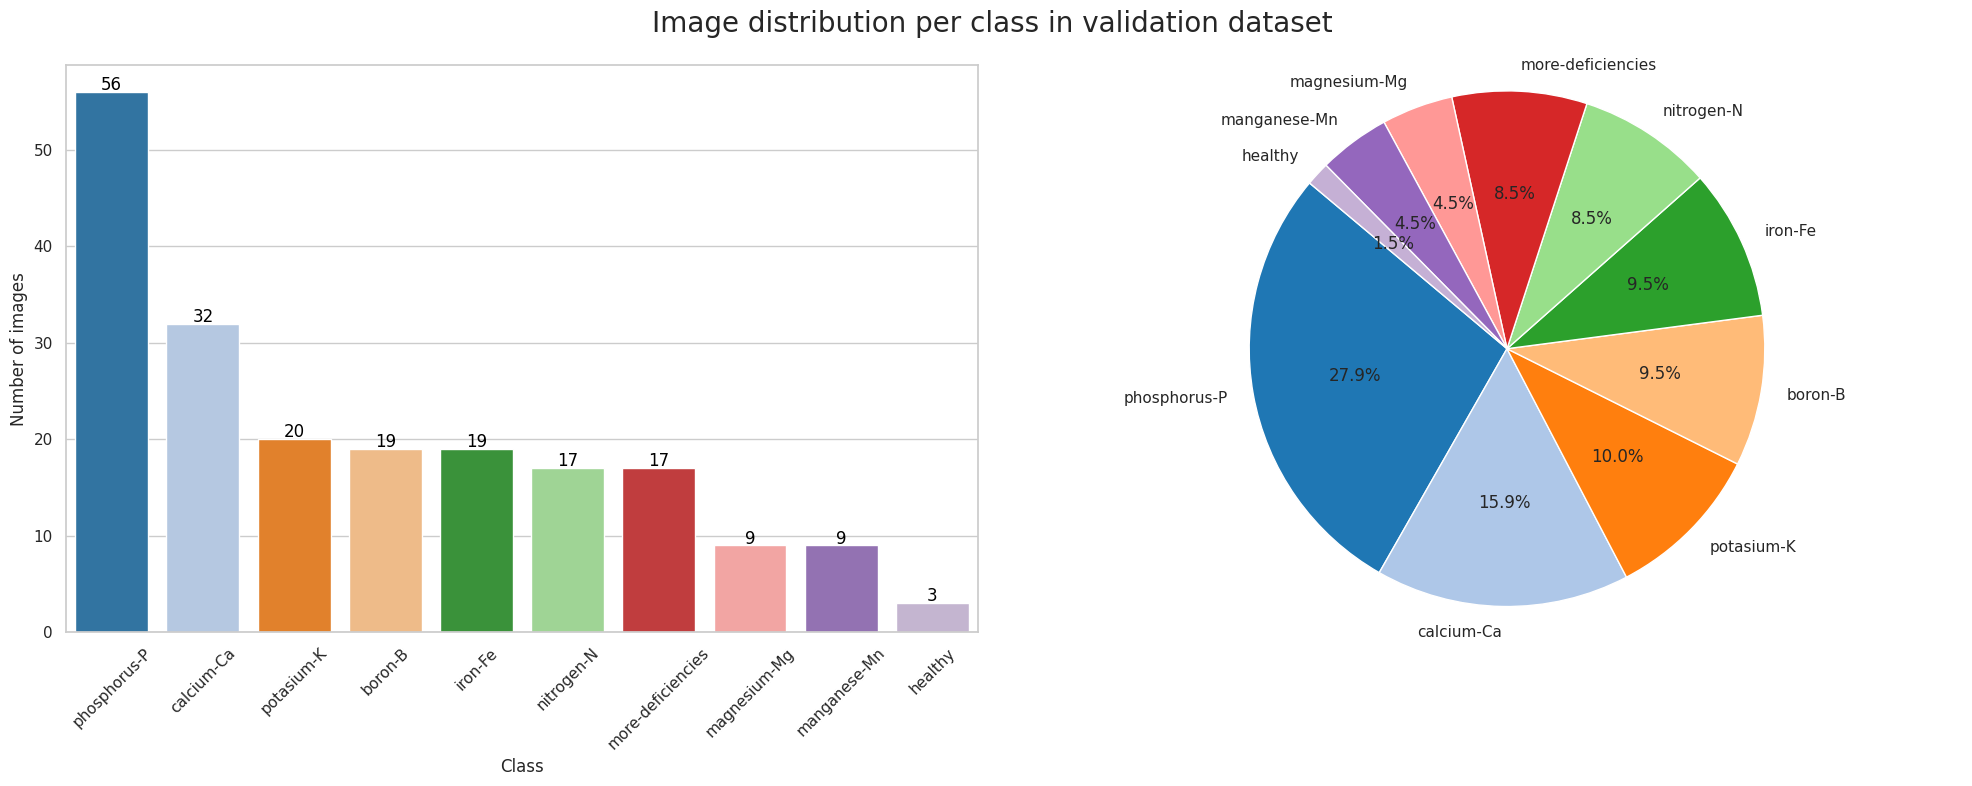

<Figure size 640x480 with 0 Axes>

In [24]:
print(f"Validation dataset: {len(val_dataset)} images")
plot_images_per_class(df_val, 'validation dataset')

Test dataset: 202 images


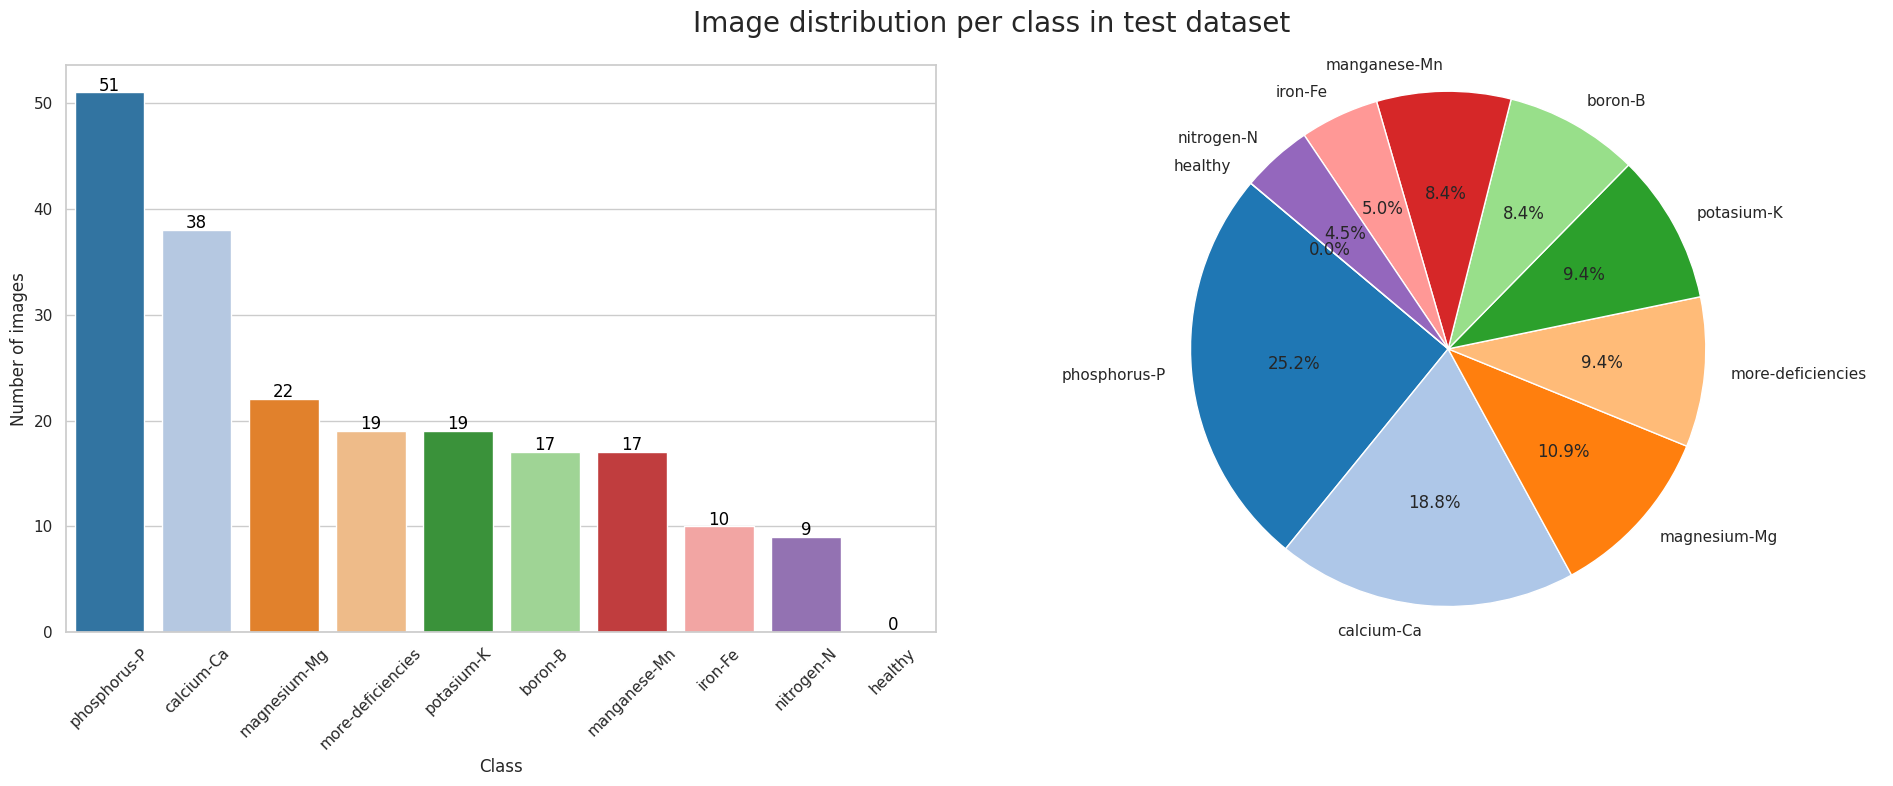

<Figure size 640x480 with 0 Axes>

In [25]:
print(f"Test dataset: {len(test_dataset)} images")
plot_images_per_class(df_test, 'test dataset')

## Data augmentation

In [40]:
data_augmentation_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

In [41]:
os.makedirs(DATASET_AUG_PATH, exist_ok=True)
max_im = df_train['Number of images'].max()
print(f"Balancing all training classes to {max_im} images.")

for i, class_name in tqdm(enumerate(dataset.classes), desc="Augmenting data...", total=len(dataset.classes)):
    class_dir = os.path.join(DATASET_AUG_PATH, class_name)
    augmented_class_dir = os.path.join(DATASET_AUG_PATH, class_name)
    os.makedirs(augmented_class_dir, exist_ok=True)
    
    class_images = [transforms.ToPILImage()(img) for img, label in train_dataset if train_dataset.classes[label] == class_name]
    
    for j, img in enumerate(class_images):
        img_path = os.path.join(class_dir, f'orig_{j}.png')
        img.save(img_path)
    
    count = df_train.loc[df_train['Class'] == class_name, 'Number of images'].iloc[0]
    num = max_im - count
    print(f"{class_name}: {count} images, creating {num} more.")

    if num > 0:        
        for _ in range(num):
            img = random.choice(class_images)
            
            augmented_img = data_augmentation_transforms(img)
            img_path = os.path.join(augmented_class_dir, f'aug_{_}.png')
            augmented_img.save(img_path)


Balancing all training classes to 147 images.


Augmenting data...: 0it [00:00, ?it/s]

boron-B: 61 images, creating 86 more.
calcium-Ca: 97 images, creating 50 more.
healthy: 4 images, creating 143 more.
iron-Fe: 39 images, creating 108 more.
magnesium-Mg: 47 images, creating 100 more.
manganese-Mn: 50 images, creating 97 more.
more-deficiencies: 62 images, creating 85 more.
nitrogen-N: 38 images, creating 109 more.
phosphorus-P: 147 images, creating 0 more.
potasium-K: 58 images, creating 89 more.


In [42]:
train_augmented = CoLeafDataset(DATASET_AUG_PATH, transform=transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
]))

Loading classes:   0%|          | 0/10 [00:00<?, ?it/s]

Loading images for class boron-B:   0%|          | 0/147 [00:00<?, ?it/s]

Loading images for class calcium-Ca:   0%|          | 0/147 [00:00<?, ?it/s]

Loading images for class healthy:   0%|          | 0/147 [00:00<?, ?it/s]

Loading images for class iron-Fe:   0%|          | 0/147 [00:00<?, ?it/s]

Loading images for class magnesium-Mg:   0%|          | 0/147 [00:00<?, ?it/s]

Loading images for class manganese-Mn:   0%|          | 0/147 [00:00<?, ?it/s]

Loading images for class more-deficiencies:   0%|          | 0/147 [00:00<?, ?it/s]

Loading images for class nitrogen-N:   0%|          | 0/147 [00:00<?, ?it/s]

Loading images for class phosphorus-P:   0%|          | 0/147 [00:00<?, ?it/s]

Loading images for class potasium-K:   0%|          | 0/147 [00:00<?, ?it/s]

In [43]:
torch.save(train_augmented, os.path.join(DATASET_PATH, 'train_augmented_dataset.pt'))

Train augmented dataset: 1470 images


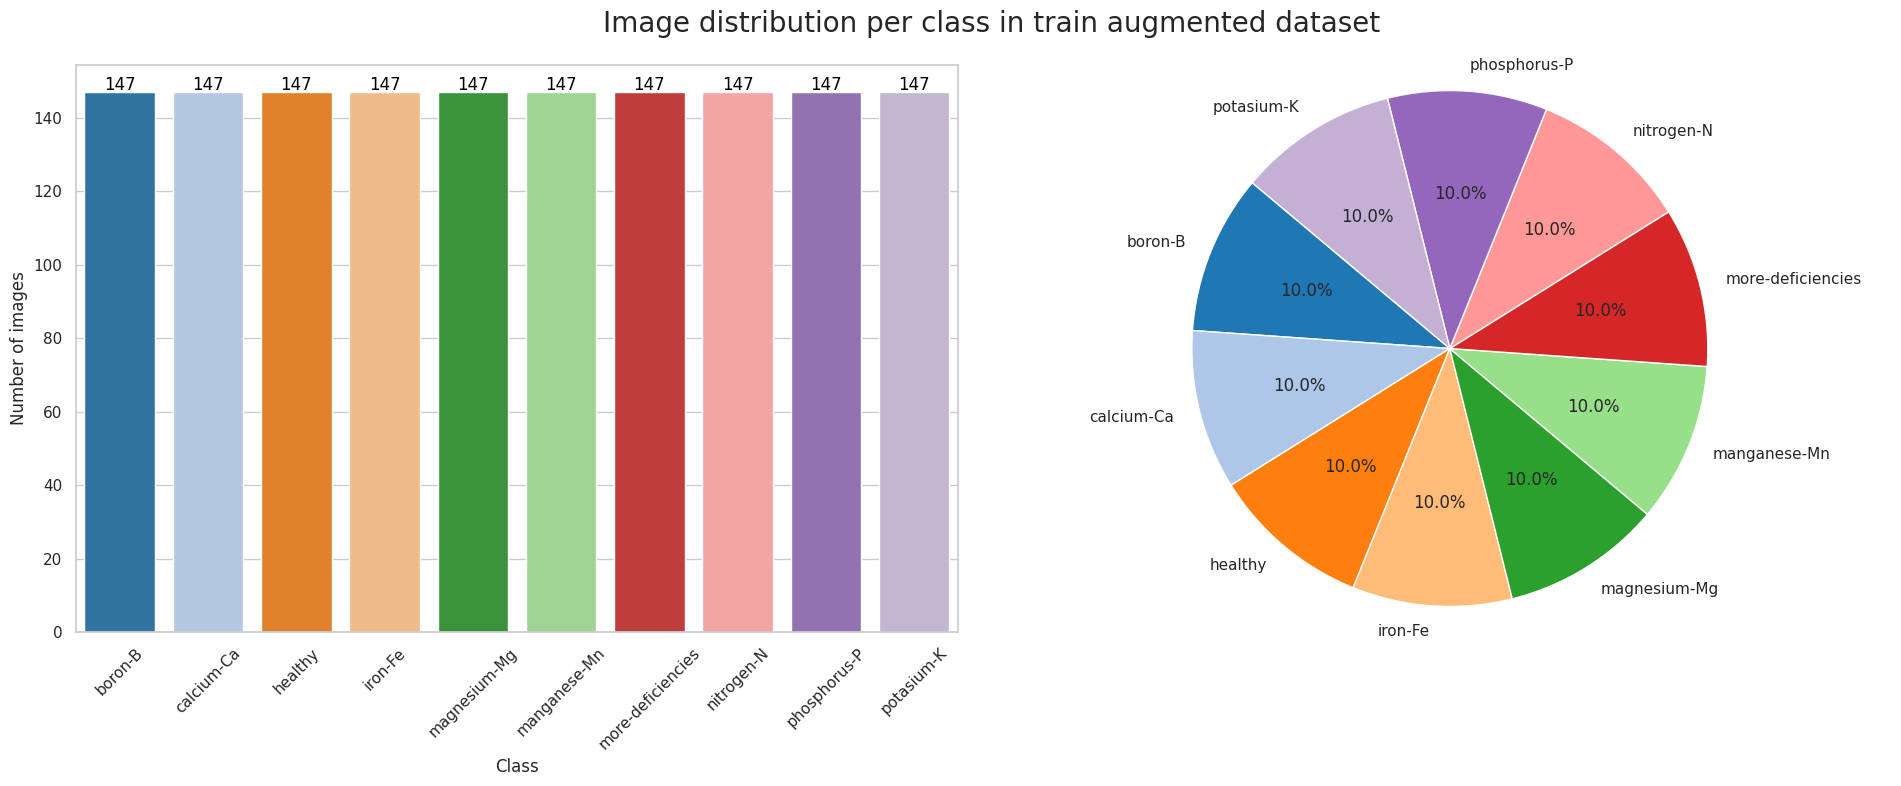

<Figure size 640x480 with 0 Axes>

In [44]:
im = []
for i in range(max(dataset.labels)+1):
    im.append(train_augmented.labels.count(i))
    
aug_df = pd.DataFrame({"Class": dataset.classes, "Number of images": im})

print(f"Train augmented dataset: {len(train_augmented)} images")
plot_images_per_class(aug_df, 'train augmented dataset')